In [2]:
# Import modules
import numpy as np # To manipulate array
import matplotlib.pyplot as plt # To visualize 2D and 3D
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation # To visualize in animation
from IPython import display # To display in html
from PIL import Image # To open Images and convert them to grayscales
from PIL import ImageFilter
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
%matplotlib inline
%matplotlib notebook

In [3]:
import os
os.chdir('Images')
print(os.getcwd())

C:\Users\admin\Lab_training\Week7_8\Images


In [4]:
def NN(img, coors, img_size):
    img_0 = img[:,:,0]
    g = torch.zeros(*img_size, 3)
    
    #NN
    coors_ = torch.round(coors).long().numpy()
    where = np.where((coors_[:,:,0]>=0)&(coors_[:,:,1]>=0)&(coors_[:,:,0]<img_0.shape[0])&(coors_[:,:,1]<img_0.shape[1]))    
    g[where] = img[coors_[where].T[:2]]
    return g

def BILINEAR(img, coors, img_size):
    img_0 = img[:,:,0]
    g = torch.zeros(*img_size, 3)
    where = np.where((coors[:,:,0]>0)&(coors[:,:,1]>0)&(coors[:,:,0]<img_0.shape[0]-1)&(coors[:,:,1]<img_0.shape[1]-1))  
    coors_ = coors[where].T[:2]

    for (h,v) in zip(where[0],where[1]):
        coor = coors[h,v].T[:2]
        p1 = torch.ceil(coor).long().numpy()
        p3 = torch.floor(coor).long().numpy()
        p2 = np.array([p1[0], p3[1]])
        p4 = np.array([p3[0], p1[1]])
        
        interp12 = img[p2[0],p2[1],:]*(coor[1]-p1[1])/(p2[1]-p1[1])+img[p1[0],p1[1],:]*(p2[1]-coor[1])/(p2[1]-p1[1])
        interp34 = img[p4[0],p4[1],:]*(coor[1]-p3[1])/(p4[1]-p3[1])+img[p3[0],p3[1],:]*(p4[1]-coor[1])/(p4[1]-p3[1])

        interp = interp34*(coor[0]-p1[0])/(p3[0]-p1[0])+interp12*(p3[0]-coor[0])/(p3[0]-p1[0])
        g[h,v] = interp
    return g

In [5]:
def geometric_transform(img, A, interpolation, img_size = (100,100)):
    L = []
    H, W = img_size
    for h in range(H):
        for w in range(W):
            L.append([h,w,1])
            #coors = torch.Tensor(L).reshape(H,W,3)
    coors = torch.Tensor(L)
    
    coors_ = (torch.linalg.pinv(A).float())@(coors.T)
    coors_ = coors_/coors_[2]
    coors_ = coors_.T.reshape(H,W,3)
    res = interpolation(img, coors_, img_size)
    return res

<IPython.core.display.Javascript object>


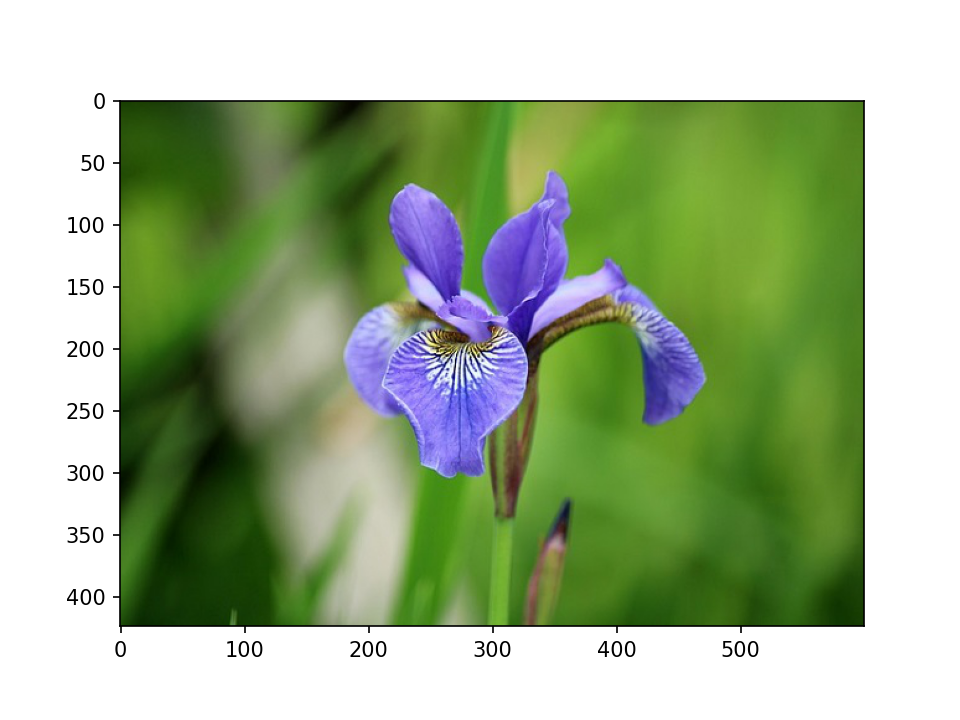

In [6]:
img_PIL = Image.open('iris.jpg')
img_ts = TF.to_tensor(img_PIL).permute(1,2,0)
plt.imshow(img_ts);

<IPython.core.display.Javascript object>


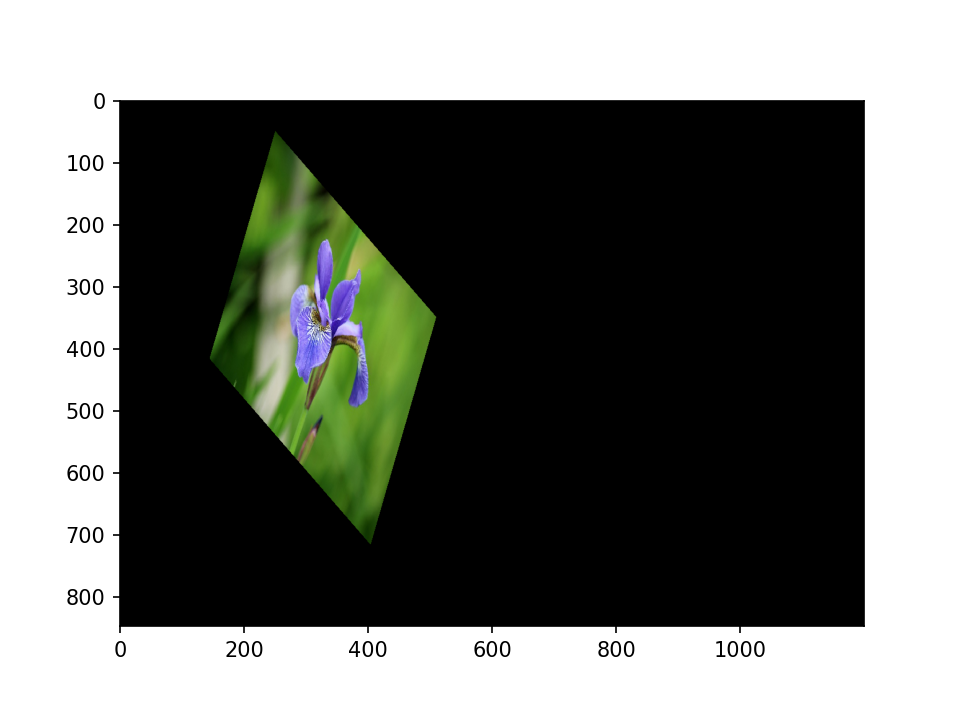

In [7]:
theta = torch.pi/6
#theta = 0
A = torch.Tensor([[np.cos(theta), np.sin(theta), 50],
                  [-1/2*np.sin(theta), 1/2*np.cos(theta),250],
                  [0, 0, 1]])
A = torch.Tensor([[np.cos(theta), np.sin(theta), 50],
                  [-1/2*np.sin(theta), 1/2*np.cos(theta),250],
                  [0, 0, 1]])

new1 = geometric_transform(img_ts, A = A , interpolation = NN, img_size = (img_ts.shape[0]*2, img_ts.shape[1]*2))
plt.figure()
plt.imshow(new1)

<IPython.core.display.Javascript object>


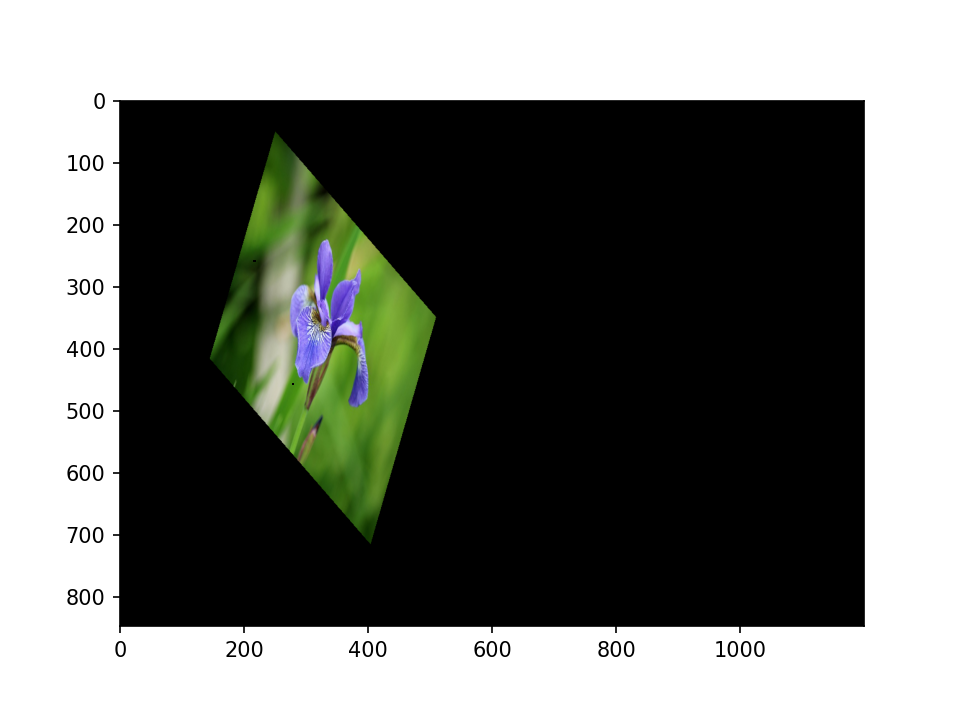

In [9]:
theta = torch.pi/6
#theta = 0
A = torch.Tensor([[np.cos(theta), np.sin(theta), 50],
                  [-1/2*np.sin(theta), 1/2*np.cos(theta),250],
                  [0, 0, 1]])
A = torch.Tensor([[np.cos(theta), np.sin(theta), 50],
                  [-1/2*np.sin(theta), 1/2*np.cos(theta),250],
                  [0, 0, 1]])

new2 = geometric_transform(img_ts, A = A , interpolation = BILINEAR, img_size = (img_ts.shape[0]*2, img_ts.shape[1]*2))
plt.figure()
plt.imshow(new2)

In [10]:
# Here is another way to build BILINEAR model. It seem to be fast when we look at it in math, but in reality it only works with small img_size!
def BILINEAR1(img, coors, img_size):
    img_0 = img[:,:,0]
    g = torch.zeros(*img_size, 3)
    where = np.where((coors[:,:,0]>0)&(coors[:,:,1]>0)&(coors[:,:,0]<img_0.shape[0]-1)&(coors[:,:,1]<img_0.shape[1]-1))  
    coors_ = coors[where].T[:2]

    ##Bilinear
    coors1 = torch.zeros_like(coors_) # up, right
    coors2 = torch.zeros_like(coors_) # up, left
    coors3 = torch.zeros_like(coors_) # down, left
    coors4 = torch.zeros_like(coors_) # down, right

    coors1 = torch.ceil(coors_)
    coors3 = torch.floor(coors_)

    coors2[0], coors2[1] = coors1[0], coors3[1]
    coors4[0], coors4[1] = coors3[0], coors1[1]
    
    d1 = coors1[1] - coors2[1] # y axis
    interp12 = torch.diag((coors_[1]-coors2[1])/d1)@img[coors1.numpy()] + torch.diag((coors1[1]-coors_[1])/d1)@img[coors2.numpy()]
    d2 = coors3[1] - coors4[1] # y axis
    interp34 = torch.diag((coors_[1]-coors4[1])/d2)@img[coors3.numpy()] + torch.diag((coors3[1]-coors_[1])/d2)@img[coors4.numpy()]
    
    d = coors1[0] - coors4[0]
    g[where] = torch.diag((coors_[0]-coors4[0])/d)@interp12 + torch.diag((coors1[0]-coors_[0]))@interp34
    return g

## Homography

In [11]:
def get_hormography_matrix(source, destination):
    A = []
    b = []
    for i in range(len(source)):
        s_x, s_y = source[i]
        d_x, d_y = destination[i]
        A.append([s_x, s_y, 1, 0, 0, 0, (-d_x)*(s_x), (-d_x)*(s_y)])
        A.append([0, 0, 0, s_x, s_y, 1, (-d_y)*(s_x), (-d_y)*(s_y)])
        b += [d_x, d_y]
    A = np.array(A)
    h = np.linalg.lstsq(A, b, rcond = -1)[0]
    h = np.concatenate((h, [1]), axis = -1)
    return np.reshape(h, (3,3))

In [12]:
source = [[0,0], [0, img_ts.shape[1]-1], [img_ts.shape[0]-1, 0], [img_ts.shape[0]-1, img_ts.shape[1]-1]]
destination = [[287, 405], [345, 768], [602, 359], [500, 768]]
H = torch.from_numpy(get_hormography_matrix(source, destination))
print(H)

tensor([[ 5.8462e-01,  6.4874e-01,  2.8700e+02],
        [-2.0420e-01,  1.8346e+00,  4.0500e+02],
        [-2.6589e-04,  1.5997e-03,  1.0000e+00]], dtype=torch.float64)


<IPython.core.display.Javascript object>


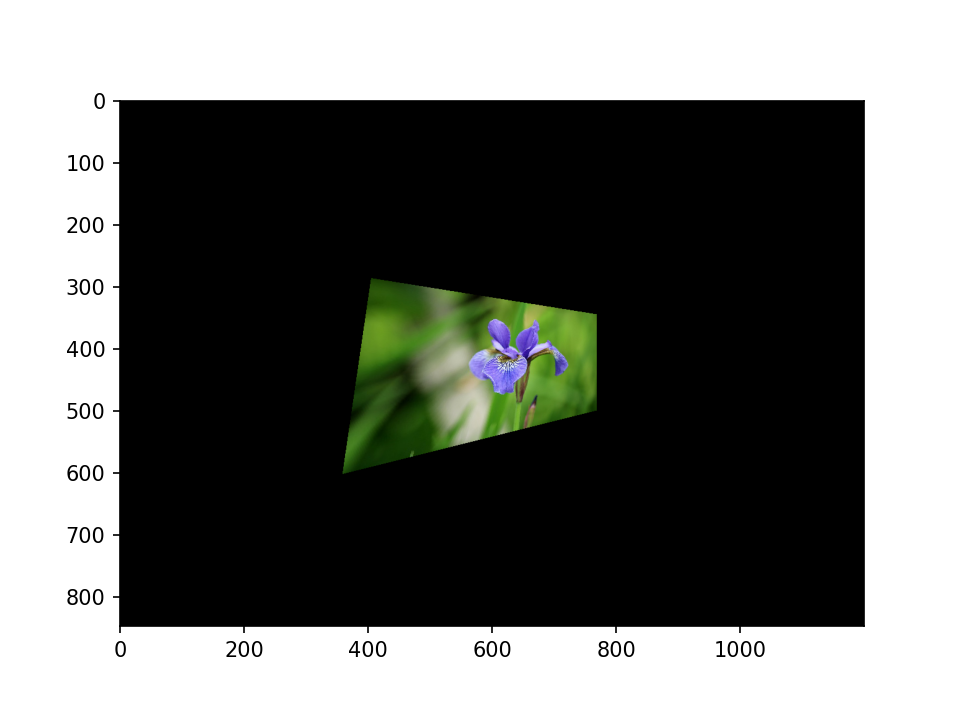

In [13]:
new3 = geometric_transform(img_ts, A = H.float(), interpolation = NN, img_size = (img_ts.shape[0]*2, img_ts.shape[1]*2))
plt.figure()
plt.imshow(new3);

<IPython.core.display.Javascript object>


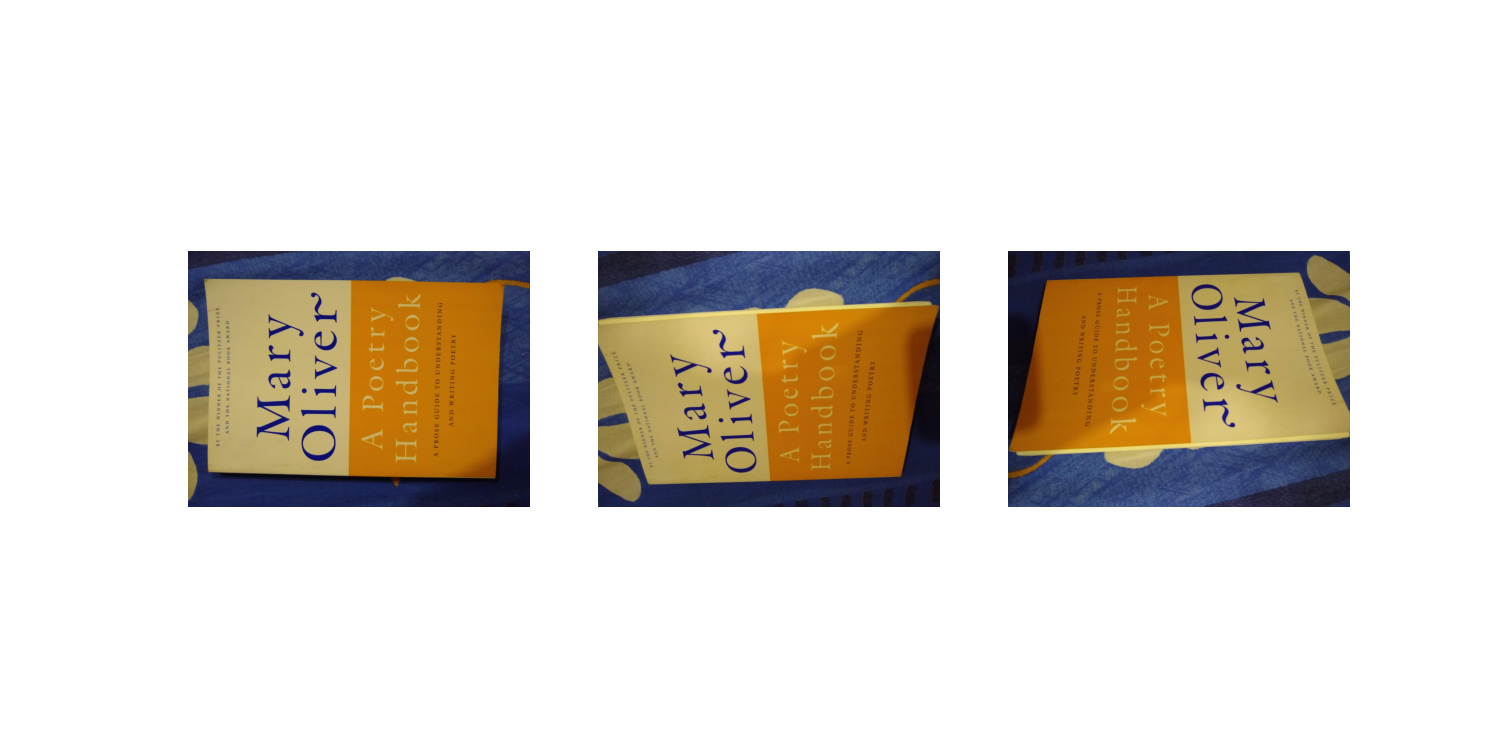

In [14]:
im = []
fig = plt.figure(figsize = (10,5))
for i in range(3):
    im.append(TF.to_tensor(Image.open(f'im{i+1}.jpg')))
    ax = fig.add_subplot(1,3,i+1)
    ax.imshow(im[-1].permute(1,2,0))
    ax.axis('off')

In [15]:
source2 = np.array([[464, 360], [318, 2022], [268, 3488], [2367, 23], [2300, 2188], [2100, 4071]])
destination2 = np.array([[316, 200], [361, 1949], [386, 3740], [2635, 234], [2685, 1908], [2693, 3657]])
H2 = torch.from_numpy(get_hormography_matrix(source2[::-1], destination2))
print(H2)

tensor([[-1.1961e+00, -1.1871e-01,  3.4069e+03],
        [ 3.7424e-01, -1.1392e+00,  4.1229e+03],
        [ 1.3794e-04, -8.2797e-06,  1.0000e+00]], dtype=torch.float64)


<IPython.core.display.Javascript object>


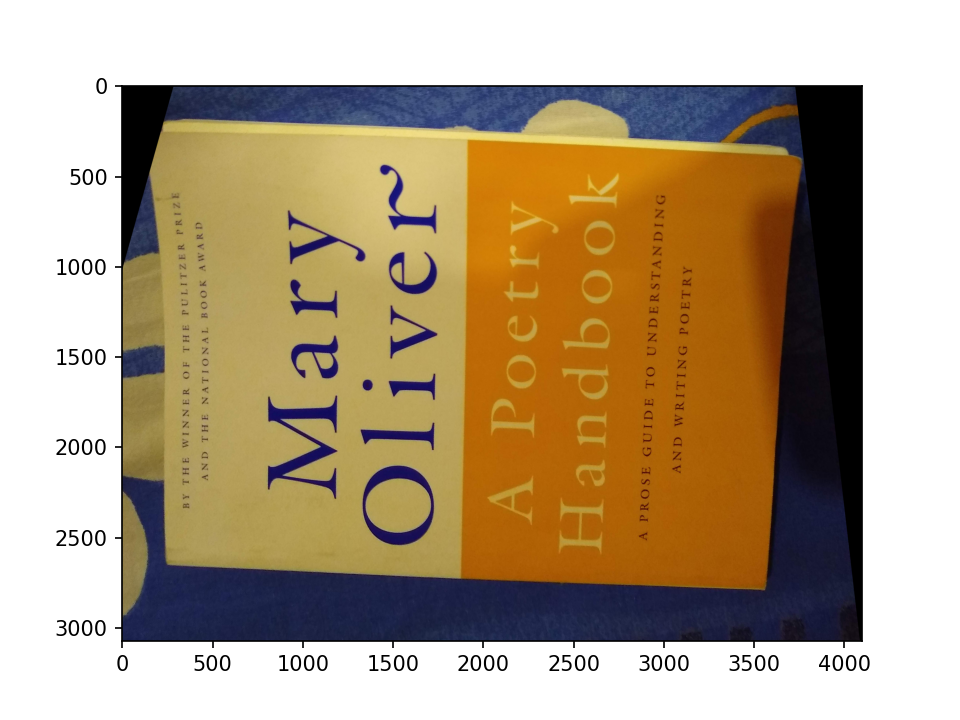

In [16]:
new4 = geometric_transform(im[2].permute(1,2,0), A = H2, interpolation = NN, img_size = (im[0].shape[1], im[0].shape[2]))
plt.figure()
plt.imshow(new4);

In [29]:
def get_hormography_matrix1(source, destination):
    #using linear regression
    A = []
    b = []
    for i in range(len(source)):
        s_x, s_y = source[i]
        d_x, d_y = destination[i]
        A.append([s_x, s_y, 1, 0, 0, 0, (-d_x)*(s_x), (-d_x)*(s_y)])
        A.append([0, 0, 0, s_x, s_y, 1, (-d_y)*(s_x), (-d_y)*(s_y)])
        b += [d_x, d_y]
    A = np.array(A)
    b = np.array(b)
    print(b.shape)
    w = np.linalg.pinv(np.dot(A.T,A))
    x = np.dot(A.T,b)
    h = w.dot(x)
    h = np.concatenate((h, [1]), axis = -1)
    return np.reshape(h, (3,3))

In [30]:
source2 = np.array([[464, 360], [318, 2022], [268, 3488], [2367, 23], [2300, 2188], [2100, 4071]])
destination2 = np.array([[316, 200], [361, 1949], [386, 3740], [2635, 234], [2685, 1908], [2693, 3657]])
H3 = torch.from_numpy(get_hormography_matrix1(source2[::-1], destination2))
print(H3)

(12,)
tensor([[-1.2213e-01,  6.1002e-01, -2.7143e+02],
        [ 1.1311e+00, -2.4214e-01,  2.6349e+02],
        [-1.1909e-04, -2.0510e-04,  1.0000e+00]], dtype=torch.float64)


<IPython.core.display.Javascript object>


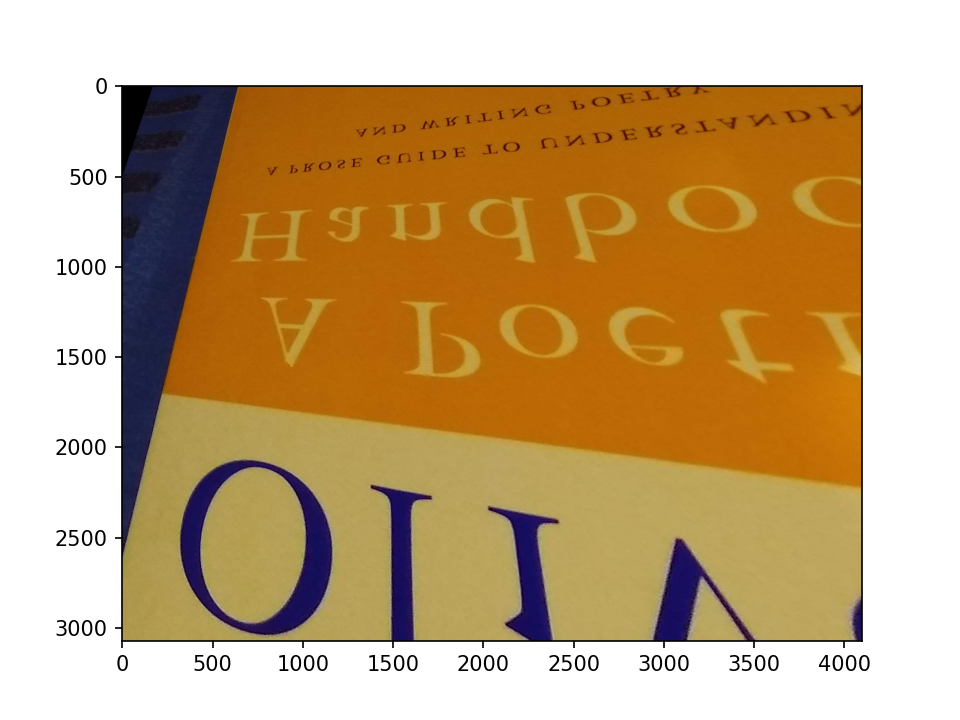

In [31]:
new5 = geometric_transform(im[2].permute(1,2,0), A = H3, interpolation = NN, img_size = (im[0].shape[1], im[0].shape[2]))
plt.figure()
plt.imshow(new5);

<IPython.core.display.Javascript object>


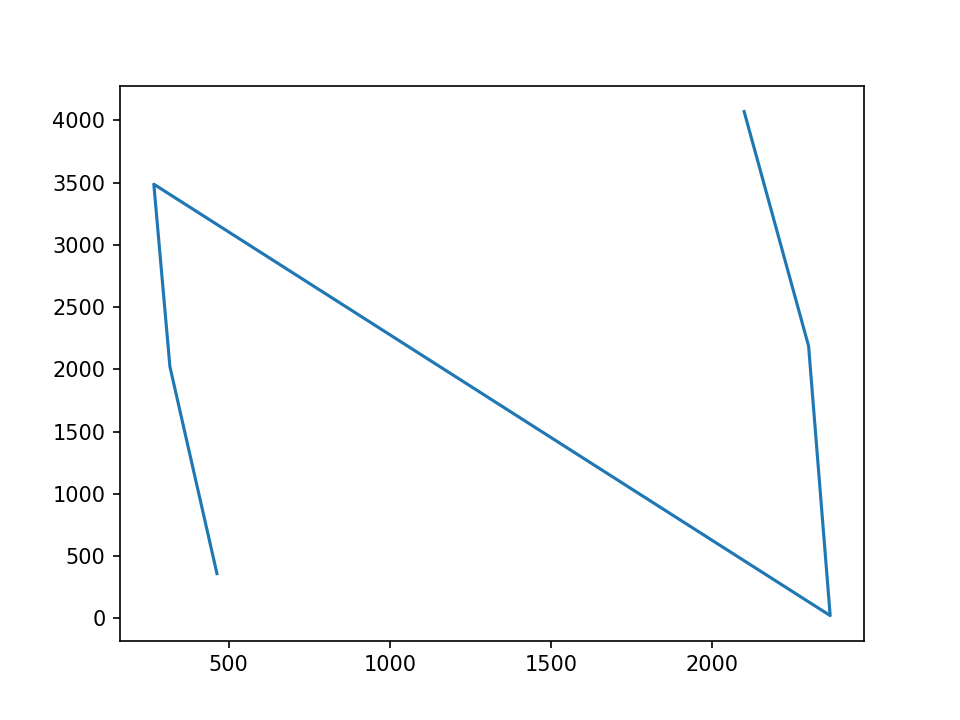

In [33]:
plt.figure()
plt.plot(source2[::-1].T[0], source2[::-1].T[1])

<IPython.core.display.Javascript object>


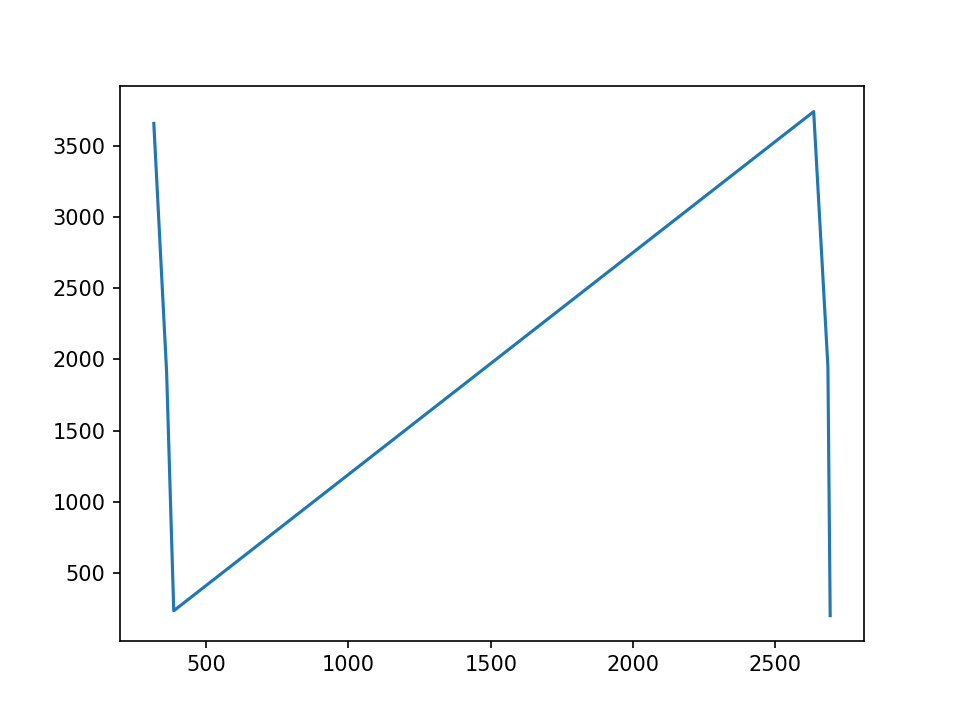

In [34]:
plt.figure()
plt.plot(destination2.T[0], destination2[::-1].T[1])